In [1]:
import matplotlib.pyplot as plt
from functools import partial

import keras
from keras.optimizers import SGD, RMSprop
import numpy as np
import pandas as pd
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, LSTM, Bidirectional, Lambda, Input, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.utils import plot_model
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_precision_score(labels, predictions):
    score = 0
    for i in range(0, len(labels)):
        if labels[i] in predictions[i]:
            score += 1
    return score / predictions.size
def get_recall_score(labels, predictions):
    score = 0
    for i in range(0, len(labels)):
        if labels[i] in predictions[i]:
            score += 1
    return score / len(labels)
def create_dataset(dataset):
    dataX, dataY = [], []
    for line in dataset.itertuples():
        lineindex = line[0]
        thislist = dataset.loc[lineindex].values
        a = thislist[:-1]
        b = thislist[-1]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [3]:
def def_model(w2vDimension, n_symbols, input_length):
    model = Sequential()
    model.add(Embedding(output_dim=w2vDimension, input_dim=n_symbols, mask_zero=False, input_length=input_length, trainable=False))
    model.add(Bidirectional(LSTM(hidden_dim_1, return_sequences=True)))
    model.add(TimeDistributed(Dense(hidden_dim_2, activation="tanh")))
    return model

In [7]:
dataframe = pd.read_csv('./datas/100thousand@6.csv', engine='python', sep='|', header=None)
input_length = dataframe.shape[1] - 1
nb_classes = dataframe.values.max() + 1
train, validation = train_test_split(dataframe, test_size=0.2, random_state=14)
print(len(train), len(validation))

X_train, Y_train = create_dataset(train)
X_valid, Y_valid = create_dataset(validation)

80000 20000


In [8]:
import gc
del train, validation
gc.collect();

In [9]:
embedding_Dimension = 100
hidden_dim_1 = 200
hidden_dim_2 = 100
NUM_CLASSES = nb_classes


base_network = def_model(embedding_Dimension, nb_classes, input_length)
input_a = Input(shape=(input_length,))
processed_a = base_network(input_a)
pool_rnn = Lambda(lambda x: K.max(x, axis=1), output_shape=(hidden_dim_2,))(processed_a)
output = Dense(NUM_CLASSES, input_dim=hidden_dim_2, activation='softmax')(pool_rnn)
rcnn_model = Model(inputs=input_a, outputs=output)
epochs = 100
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
top20_acc = partial(keras.metrics.sparse_top_k_categorical_accuracy, k=20)
top20_acc.__name__ = 'acc'
rcnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=[top20_acc])
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1)]


In [10]:
print(rcnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 5, 100)            5210800   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46891)             4735991   
Total params: 9,946,791
Trainable params: 5,257,691
Non-trainable params: 4,689,100
_________________________________________________________________
None


In [ ]:
history = rcnn_model.fit(X_train, Y_train, batch_size=128, epochs=epochs, verbose=2, validation_data=(X_valid, Y_valid), callbacks=callbacks)

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
 - 135s - loss: 9.2825 - acc: 0.3543 - val_loss: 7.5259 - val_acc: 0.3579
Epoch 2/100


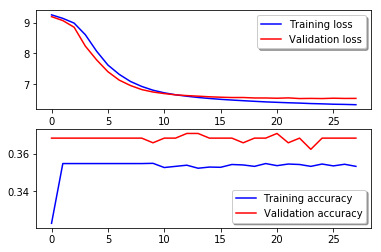

In [9]:
#**************************--output--****************************************
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()
#*****************************************************************************

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


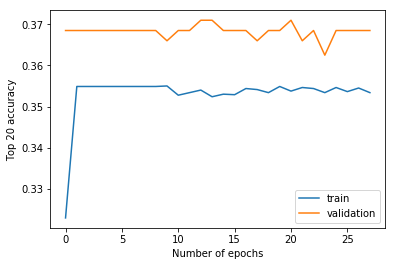

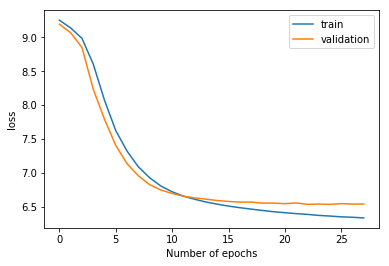

In [16]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
plt.ylabel('Top 20 accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'validation'], loc='best')
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('Top 20 accuracy.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'validation'], loc='best')
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('model loss.eps', format='eps', dpi=1000)
plt.show()

In [14]:
y_proba = rcnn_model.predict(X_valid, verbose=0)
y_pred = y_proba.argmax(axis=1)
k = 20
y_predTopk = np.argsort(y_proba, axis=1)[:, y_proba.shape[1] - k::]
pre = get_precision_score(Y_valid, y_predTopk)
recall = get_recall_score(Y_valid, y_predTopk)
F1 = 2 * pre * recall / (pre + recall)
print('Precision:{0}\tRecall:{1}\tF1:{2}'.format(pre, recall, F1))
score = rcnn_model.evaluate(X_valid, Y_valid, verbose=0)
print(score)
# prediction=rcnn_model.predict_classes(X_test)
testprecision = precision_score(Y_valid, y_pred, average='micro')
print("Precision score for classification model - ", testprecision)

Precision:0.018425	Recall:0.3685	F1:0.035095238095238096
[6.5369653968811035, 0.3685]
Precision score for classification model -  0.1135


In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_valid, y_pred)

0.1135

In [28]:
y_predTopk

array([[840],
       [840],
       [840],
       ..., 
       [840],
       [840],
       [840]], dtype=int64)

In [23]:
y_predTopk.max()

2405

In [24]:
y_predTopk.min()

2405